In [23]:
from typing import Any, Union
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

# sns.set()
sns.set_theme()

In [24]:
# Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'neurips':
        width_pt = 397.48499
    elif width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [25]:
def load_train_results(filepath: Union[str, Path]) -> tuple[list, dict[str, Any]]:
    """Loads training results from JSON file."""
    with open(str(filepath), 'r') as f:
        d = json.load(f)
    return d['reward'], d['metrics']

In [26]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [27]:
def plot_with_errorbar(ax, data, label, color, plot_method: str = 'mean', error_method: str = 'std', plot_error: bool = True, plot_kwargs: dict = {}, fill_kwargs: dict = {}, **kwargs):
    
    ###
    # Method to highlight the main plot data.
    ###
    y = data
    
    # Plots the average run value at each epoch.
    if plot_method == 'mean':
        y = np.mean(data, axis=0) # (3000,)
        
    elif plot_method == 'mean-rolling':
        df = pd.DataFrame(np.mean(data, axis=0))
        y = df.rolling(10).mean().to_numpy().flatten()
    
    # Plots the run with the maximum average value over the last `n` epochs.
    elif plot_method.startswith('max-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_max = np.argmax(avg_last_n)
        y = data[idx_max] # Plot data is the index of the max.
        
    # Plots the run with the minimum average value over the last `n` epochs.
    elif plot_method.startswith('min-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_min = np.argmin(avg_last_n)
        y = data[idx_min] # Plot data is the index of the min.
    
    else:
        raise ValueError(f"Unsupported plot highlight {plot_method}")
    
    ###
    # Method to produce the shaded error regions.
    ###
    if plot_error:
    
        # Shaded region is +/- standard deviation from the designated `y`-value.
        if error_method.startswith('std') and 'rolling' not in error_method:
            y_std = np.std(data, axis=0)# (3000,)
            n = 1 # Default is 1 std above/below the data.
            if '-' in error_method: # Pull `n` value from method type.
                n = int(error_method.split('-')[-1])
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'std-rolling':
            y_std = pd.DataFrame(y).rolling(10).std().to_numpy().flatten()
            n = 1 # Default is 1 std above/below the data.
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        # Shaded region is minimum/maximum values at each epoch.
        elif error_method == 'minmax':
            y_min = np.min(data, axis=0) # (3000,)
            y_max = np.max(data, axis=0)# (3000,)
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'minmax-rolling':
            y_min = pd.DataFrame(np.min(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            y_max = pd.DataFrame(np.max(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        else:
            raise ValueError(f"Unsupported error method {error_method}")
    
    else:
        x = np.arange(data.shape[-1])
        ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))



In [28]:
def plot_with_errorbar_3d(index, ax, data, label, color, plot_method: str = 'mean', error_method: str = 'std', plot_kwargs: dict = {}, fill_kwargs: dict = {}, **kwargs):
    
    ###
    # Method to highlight the main plot data.
    ###
    y = data
    
    # Plots the average run value at each epoch.
    if plot_method == 'mean':
        y = np.mean(data, axis=0) # (3000,)
    
    # Plots the run with the maximum average value over the last `n` epochs.
    elif plot_method.startswith('max-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_max = np.argmax(avg_last_n)
        y = data[idx_max] # Plot data is the index of the max.
        
    # Plots the run with the minimum average value over the last `n` epochs.
    elif plot_method.startswith('min-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_min = np.argmin(avg_last_n)
        y = data[idx_min] # Plot data is the index of the min.
    
    else:
        raise ValueError(f"Unsupported plot highlight {plot_method}")
    
    ###
    # Method to produce the shaded error regions.
    ###
    
    # Shaded region is +/- standard deviation from the designated `y`-value.
    if error_method.startswith('std'):
        y_std = np.std(data, axis=0)# (3000,)
        n = 1 # Default is 1 std above/below the data.
        if '-' in error_method: # Pull `n` value from method type.
            n = int(error_method.split('-')[-1])
        x = np.arange(data.shape[-1])
        z = np.zeros_like(x) + index
        ax.plot(x, z, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
    
    # Shaded region is minimum/maximum values at each epoch.
    elif error_method == 'minmax':
        y_min = np.min(data, axis=0) # (3000,)
        y_max = np.max(data, axis=0)# (3000,)
        x = np.arange(data.shape[-1])
        z = np.zeros_like(x) + index
        ax.plot(x, z, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
    
    else:
        raise ValueError(f"Unsupported error method {error_method}")



In [29]:
series = {
    'eQMARL': '~/Downloads/output/coingame_maa2c_quantum_mdp/20240418T140126/metrics-[0-5].json',
    'classical Central CTDE': '~/Downloads/output/coingame_maa2c_classical_mdp_central/20240501T185443/metrics-[0-5].json',
    'classical Split CTDE': '~/Downloads/output/coingame_maa2c_classical_mdp/20240418T133421/metrics-[0-5].json',
}

color_map = {k:c for k,c in zip(series, sns.color_palette())}
color_map

{'eQMARL': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'classical Central CTDE': (0.8666666666666667,
  0.5176470588235295,
  0.3215686274509804),
 'classical Split CTDE': (0.3333333333333333,
  0.6588235294117647,
  0.40784313725490196)}

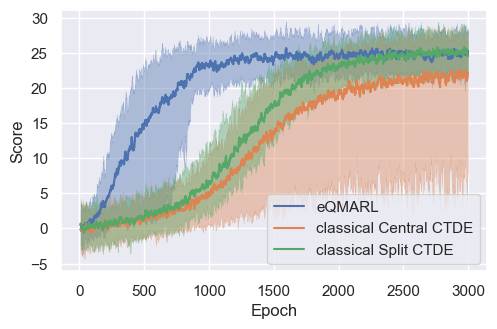

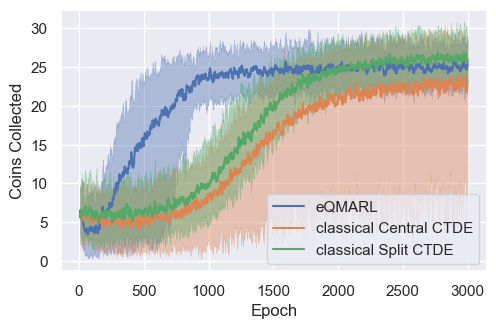

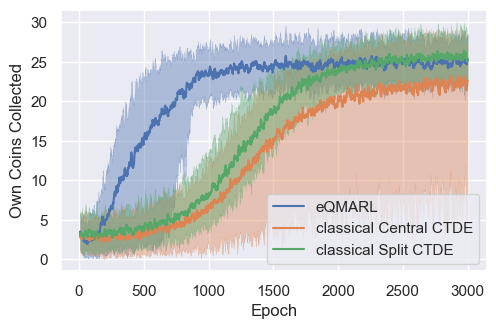

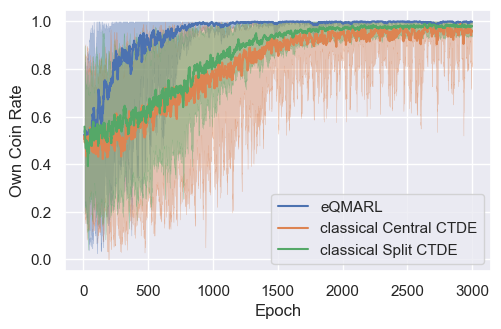

In [32]:
figures = [
    dict(
        type='subplots',
        kwargs=dict(
            # figsize=(7,5),
            # figsize=(11.69,8.27,),
            figsize=set_size('neurips'),
        ),
        ax=[
            dict(
                metric='undiscounted_reward',
                xlabel='Epoch',
                ylabel='Score',
                series=[
                    dict(
                        key=k,
                        label=k,
                        color=color_map[k],
                        # plot_method='mean',
                        plot_method='mean-rolling',
                        # error_method='std',
                        # error_method='minmax',
                        error_method='minmax-rolling',
                        # error_method='std-rolling',
                        plot_kwargs=dict(linewidth=1.5),
                        # plot_kwargs=dict(s=.3, zorder=len(series)-i),
                        fill_kwargs=dict(alpha=0.4, linewidth=0.2)
                    ) for k in series
                ],
                legend_kwargs=dict(loc='lower right'),
            ),
        ],
    ),
    
    dict(
        type='subplots',
        kwargs=dict(
            # figsize=(7,5),
            figsize=set_size('neurips'),
        ),
        ax=[
            dict(
                metric='coins_collected',
                xlabel='Epoch',
                ylabel='Coins Collected',
                series=[
                    dict(
                        key=k,
                        label=k,
                        color=color_map[k],
                        # plot_method='mean',
                        plot_method='mean-rolling',
                        # error_method='std',
                        # error_method='minmax',
                        error_method='minmax-rolling',
                        # error_method='std-rolling',
                        plot_kwargs=dict(linewidth=1.5),
                        fill_kwargs=dict(alpha=0.4, linewidth=0.2)
                    ) for k in series
                ],
                legend_kwargs=dict(loc='lower right'),
            ),
        ],
    ),
    
    dict(
        type='subplots',
        kwargs=dict(
            # figsize=(7,5),
            figsize=set_size('neurips'),
        ),
        ax=[
            dict(
                metric='own_coins_collected',
                xlabel='Epoch',
                ylabel='Own Coins Collected',
                series=[
                    dict(
                        key=k,
                        label=k,
                        color=color_map[k],
                        # plot_method='mean',
                        plot_method='mean-rolling',
                        # error_method='std',
                        # error_method='minmax',
                        error_method='minmax-rolling',
                        # error_method='std-rolling',
                        plot_kwargs=dict(linewidth=1.5),
                        fill_kwargs=dict(alpha=0.4, linewidth=0.2)
                    ) for k in series
                ],
                legend_kwargs=dict(loc='lower right'),
            ),
        ],
    ),
    
    dict(
        type='subplots',
        kwargs=dict(
            # figsize=(7,5),
            figsize=set_size('neurips'),
        ),
        ax=[
            dict(
                metric='own_coin_rate',
                xlabel='Epoch',
                ylabel='Own Coin Rate',
                series=[
                    dict(
                        key=k,
                        label=k,
                        color=color_map[k],
                        plot_method='mean-rolling',
                        # error_method='std',
                        # error_method='minmax',
                        error_method='minmax-rolling',
                        # error_method='std-rolling',
                        plot_kwargs=dict(linewidth=1.5),
                        # plot_kwargs=dict(s=.3, zorder=len(series)-i),
                        fill_kwargs=dict(alpha=0.4, linewidth=0.2),
                        # plot_error=False,
                    ) for i, k in enumerate(series)
                ],
                legend_kwargs=dict(loc='lower right'),
            ),
        ],
    ),
]



# Collect all data from all series and put into frames.
series_df: dict[str, pd.DataFrame] = {}
for key,blob in series.items():
    
    files = glob.glob(str(Path(blob).expanduser()))
    session_reward_history = []
    session_metrics_history = []
    for f in files:
        reward_history, metrics_history = load_train_results(str(f))
        session_reward_history.append(reward_history)
        session_metrics_history.append(metrics_history)
        
    # Reshape to proper matrix.
    session_reward_history = session_reward_history
    session_reward_history = np.array(session_reward_history)
    
    df = pd.DataFrame(session_metrics_history)
    series_df[key] = df



# Generate figures.
for fig_kwargs in figures:
    
    if fig_kwargs['type'] == 'subplots':
        # fig, ax = plt.subplots(**fig_kwargs['kwargs'], subplot_kw=dict(projection='3d'))
        fig, ax = plt.subplots(**fig_kwargs['kwargs'])
        if not isinstance(ax, list):
            ax = [ax]
        ax = np.array(ax).flatten()
        
        for ax_idx, ax_kwargs in enumerate(fig_kwargs['ax']):
            # print(ax_idx, ax_kwargs)
            
            for j, series_kwargs in enumerate(ax_kwargs['series']):
                df = series_df[series_kwargs['key']]
                df_arr = np.array(df.values.tolist())
                i = list(df.columns).index(ax_kwargs['metric']) # Index of metric key within frame column.
                
                # data = df_arr[:,i,:]
                # dft = pd.DataFrame(np.mean(data, axis=0))
                # y = dft.rolling(10).mean()
                # print(y)
                # plt.figure()
                # plt.plot(np.mean(data, axis=0))
                # plt.plot(y)
                # plt.show()
                # # print(dft.rolling(100))
                
                # data = df_arr[:,i,:]
                # df = pd.DataFrame(np.mean(data, axis=0))
                # y = df.rolling(10).mean().to_numpy().flatten()
                # y_std = pd.DataFrame(y).rolling(10).std().to_numpy().flatten()*10
                
                # print(f"{y=}")
                # print(f"{y_std=}")
                
                # # plt.figure()
                # x = np.arange(y.shape[-1])
                # plt.plot(x, y)
                # plt.fill_between(x, y-y_std, y+y_std, **series_kwargs['fill_kwargs'])
                # # plt.show()
                # print(here)
                
                # print(www)
                
                plot_with_errorbar(ax[ax_idx], df_arr[:,i,:], **series_kwargs)
                # plot_with_errorbar_3d(j, ax[ax_idx], df_arr[:,i,:], **series_kwargs)
                
                # new_df = pd.DataFrame(df_arr[:,i,:])
                # print(new_df)
                # print(new_df.mean())
                # print(new_df.std())
                # sns.relplot(new_df.mean(), kind='line')
                # # as;djfhasojdfh
                # print(www)
                # # sns.lineplot(df, x=)
            
            # Turn on legend.
            ax[ax_idx].legend(**ax_kwargs['legend_kwargs'])
            
            # Set axis title.
            title = None
            if 'title' in ax_kwargs:
                title = ax_kwargs['title']
            ax[ax_idx].set_title(title)
            
            # Set axis X-label.
            if 'xlabel' in ax_kwargs:
                ax[ax_idx].set_xlabel(ax_kwargs['xlabel'])
            
            # Set axis Y-label.
            if 'ylabel' in ax_kwargs:
                ax[ax_idx].set_ylabel(ax_kwargs['ylabel'])



In [31]:
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367
